In [56]:
from Bio import SeqIO
for record in SeqIO.parse("pdb/2m7d.pdb", "pdb-seqres"):
    print("Record id %s, chain %s" % (record.id, record.annotations["chain"]))
    print(record)
len(record.seq)

Record id 2M7D:A, chain A
ID: 2M7D:A
Name: 2M7D:A
Description: PDB:2M7D 2M7D
Database cross-references: PDB:2M7D, PDB:2M7D
Number of features: 0
/chain=A
/molecule_type=protein
Seq('DAYAQWLADXGWASXRPPPS')


20

In [119]:
amino_acid_codes = {
    "ALA": "A",
    "ARG": "R",
    "ASN": "N",
    "ASP": "D",
    "CYS": "C",
    "GLN": "Q",
    "GLU": "E",
    "GLY": "G",
    "HIS": "H",
    "ILE": "I",
    "LEU": "L",
    "LYS": "K",
    "MET": "M",
    "PHE": "F",
    "PRO": "P",
    "SER": "S",
    "THR": "T",
    "TRP": "W",
    "TYR": "Y",
    "VAL": "V"
}

In [120]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Chain import Chain
from Bio.PDB.internal_coords import *
from Bio.PDB.PICIO import write_PIC, read_PIC, read_PIC_seq
from Bio.PDB.ic_rebuild import write_PDB, IC_duplicate, structure_rebuild_test
from Bio.PDB.SCADIO import write_SCAD
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.PDB.PDBIO import PDBIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from Bio.PDB import PDBList

window_size = 7

protein_ids = ['2m7d', '7B3Y', '8C9N', '7LYJ', '6YUN', '7QCT', '6XRZ', '8UYS', '8FU7']
protein_ids = [protein_ids[1]]
proteins = []

phi_psi = pd.DataFrame(columns=['seq','phi', 'psi', 'chain', 'pos_in_chain', 'protein_id'])

for protein_id in protein_ids:
    parser = PDBParser()

    filename = f"pdb/{protein_id}.pdb"
    filename_ent = f"pdb/pdb{str(protein_id).lower()}.ent"
    if Path(filename).is_file():
        protein = parser.get_structure(protein_id, filename)
    elif Path(filename_ent).is_file():
        protein = parser.get_structure(protein_id, filename_ent)
    else:
        print(f"Downloading {protein_id}")
        pdbl = PDBList()
        filename = pdbl.retrieve_pdb_file(protein_id, pdir='pdb', file_format='pdb', obsolete=False)
        if Path(filename).is_file():
            protein = parser.get_structure(protein_id, filename)

    proteins.append(protein)
    for chain in list(protein.get_chains()):
        chain = protein[0][chain.id]
        if chain.id in phi_psi.chain.unique():
            print(f'Duplicate chain found {protein_id} {chain.id}')
            continue

        chain.atom_to_internal_coordinates(verbose=True)
        resultDict = structure_rebuild_test(chain)
        if not resultDict['pass']:
            print(f"Failed {protein_id} {chain.id}")
            continue

        residues = list(chain.get_residues())
        # for i in range(1,len(residues)-1):
        #     key = f'{residues[i-1].resname}, {residues[i].resname}, {residues[i+1].resname}'
        #     if not residues[i].internal_coord:
        #         psi,phi = np.nan, np.nan
        #     else:
        #         psi = residues[i].internal_coord.get_angle("psi")
        #         phi = residues[i].internal_coord.get_angle("phi")
        #     phi_psi.loc[len(phi_psi)] = [key, phi, psi, chain.id, residues[i].get_full_id()[3][1], protein.id]
        for i in range(len(residues) - window_size):
            # Convert 3 char codes to 1 char codes
            key = ''.join([amino_acid_codes.get(r.resname, 'X') for r in residues[i:i+window_size]])
            if not residues[i].internal_coord:
                psi,phi = np.nan, np.nan
            else:
                psi = residues[i].internal_coord.get_angle("psi")
                phi = residues[i].internal_coord.get_angle("phi")
            phi_psi.loc[len(phi_psi)] = [key, phi, psi, chain.id, residues[i].get_full_id()[3][1], protein.id]


chain B len 202 missing atom(s): [0_K_CB]
chain B len 202 missing atom(s): [1_M_CB]


/var/folders/pr/kj9ky04n4_q058ntx_2k9y540000gn/T/ipykernel_27146/77469078.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  phi_psi.loc[len(phi_psi)] = [key, phi, psi, chain.id, residues[i].get_full_id()[3][1], protein.id]


In [121]:
phi_psi = phi_psi[~phi_psi.isna().any(axis=1)]
phi_psi

,seq,phi,psi,chain,pos_in_chain,protein_id
1,MEELFKK,-55.383822,-42.039538,B,1,7B3Y
2,EELFKKH,-62.644340,-41.729978,B,2,7B3Y
3,ELFKKHK,-73.039212,-30.098693,B,3,7B3Y
4,LFKKHKI,-69.596234,-43.633734,B,4,7B3Y
5,FKKHKIV,-58.284522,-46.478356,B,5,7B3Y
...,...,...,...,...,...,...
190,KAKAFVE,-62.306483,-36.795092,B,190,7B3Y
191,AKAFVEK,-49.983879,-48.714901,B,191,7B3Y
192,KAFVEKI,-60.991431,-46.638402,B,192,7B3Y
193,AFVEKIR,-58.802511,-46.101293,B,193,7B3Y


# PDB Mine API

In [126]:
from Bio import SeqIO
protein_id = protein_ids[0]
for record in SeqIO.parse(f"pdb/pdb{protein_id}.ent", "pdb-seqres"):
    print(len(record.seq),record)

341 ID: 7B3Y:B
Name: 7B3Y:B
Description: UNP:A0A0H3BX48 A0A0H3BX48_STRPZ
Database cross-references: UNP:A0A0H3BX48, UNP:A0A0H3BX48_STRPZ, UNP:Q9WXS1, UNP:Q9WXS1_THEMA
Number of features: 0
/chain=B
/molecule_type=protein
Seq('MGSSVTTLSGLSGEQGPSGDMTTEEDSATHIKFSKRDEDGRELAGATMELRDSS...PEA')


In [133]:
from dotenv import load_dotenv
import os
import requests
import time
import pandas as pd
load_dotenv()
PDBMINE_URL = os.getenv("PDBMINE_URL")

# response = requests.get(PDBMINE_URL + f'/v1/api/protein/7B3Y', verify=False)
# assert(response.ok)
# protein_data = response.json()

# - residue_chain is some string of amino acids - any length
# - window_size is length sliding window that will create windows of amino
#   acids to search for. Eg. AKYVCKICGYIYDEDAGDPDNGVSPG with window size 7 
#   will create and search for the following windows:
#    - AKYVCKI, KYVCKIC, YVCKICG, VCKICGY, ...
# - code_length is the length of the amino acid codes used in the residue_chain (1 or 3)
residue_chain = str(record.seq)
window_size = 7
code_length = 1
response = requests.post(
    PDBMINE_URL + '/v1/api/query',
    json={
        "residueChain": residue_chain,
        "codeLength": code_length,
        "windowSize": window_size
    }
)
assert(response.ok)
print(response.json())
query_id = response.json().get('queryID')
assert(query_id)

{'status': 'Running', 'queryID': '1b26fef4-e61a-11ee-b41b-0242ac110002'}


In [146]:
response = requests.get(PDBMINE_URL + f'/v1/api/query/{query_id}')
if response.ok:
    matches = response.json()['frames']

- matches contains keys for each window, eg. 000_AKYVCKI, 001_KYVCKIC, 002_YVCKICG, ...
- each window entry contains keys of the protein and chain of matches for that
  window, eg. 2JOF_A, 2LL5_A, 3UC7_A, 3UC7_B
- each match entry contains a list of matches for that protein and chain,
  where each match is a list of the residues in the window and the phi,psi of each residu

For example:
```python
{
  '000_DAYAQWL': {
    '2JOF_A': [
      [
          {'residueName': 'D', 'phi': 360, 'psi': 129.2},
          {'residueName': 'A', 'phi': -65.3, 'psi': -40.7},
          (Y,A,Q,W,L)... 
      ],
      [
          {'residueName': 'D', 'phi': 360, 'psi': 132.8},
          {'residueName': 'A', 'phi': -65.3, 'psi': -40.7},
          (Y,A,Q,W,L)...
      ],
      ...
    ],
    '2LL5_A': [
      ...
    ]
  },
  '001_AYAQWLA': {
    ...
  },
  (rest of windows) ...
}
```

In [148]:
# Want to plot the phi, psi angles distrubution for the first residue in each window
# and compare to phi psi of the first residue in the same window in the protein from PDB
phi_psi_mined = pd.DataFrame(columns=['seq','phi', 'psi', 'chain', 'protein_id'])
for k,v in matches.items():
    seq = k[4:]
    for protein,seq_matches in matches[k].items():
        # get phi and psi of first resiude of window for each match
        protein_id, chain = protein.split('_')
        for seq_match in seq_matches:
            phi, psi = seq_match[0]['phi'], seq_match[0]['psi']
            phi_psi_mined.loc[len(phi_psi_mined)] = [seq, phi, psi, chain, protein_id]

In [149]:
phi_psi_mined.to_csv('7B3Y_phi_psi_mined.csv', index=False)
phi_psi.to_csv('7B3Y_phi_psi.csv', index=False)

In [107]:
phi_psi_mined = pd.read_csv('2m7d_phi_psi_mined.csv')
phi_psi = pd.read_csv('2m7d_phi_psi.csv')
protein_id_pdb = '2m7d'

In [158]:
phi_psi.protein_id.unique()[0]

'7B3Y'

In [175]:
# phi_psi_dist.apply(lambda x: {k:v for v,k in enumerate(phi_psi_dist['protein_id'].unique())}[x])
[{k:v for v,k in enumerate(phi_psi_dist['protein_id'].unique())}[x] for x in phi_psi_dist['protein_id']]

[0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 4,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

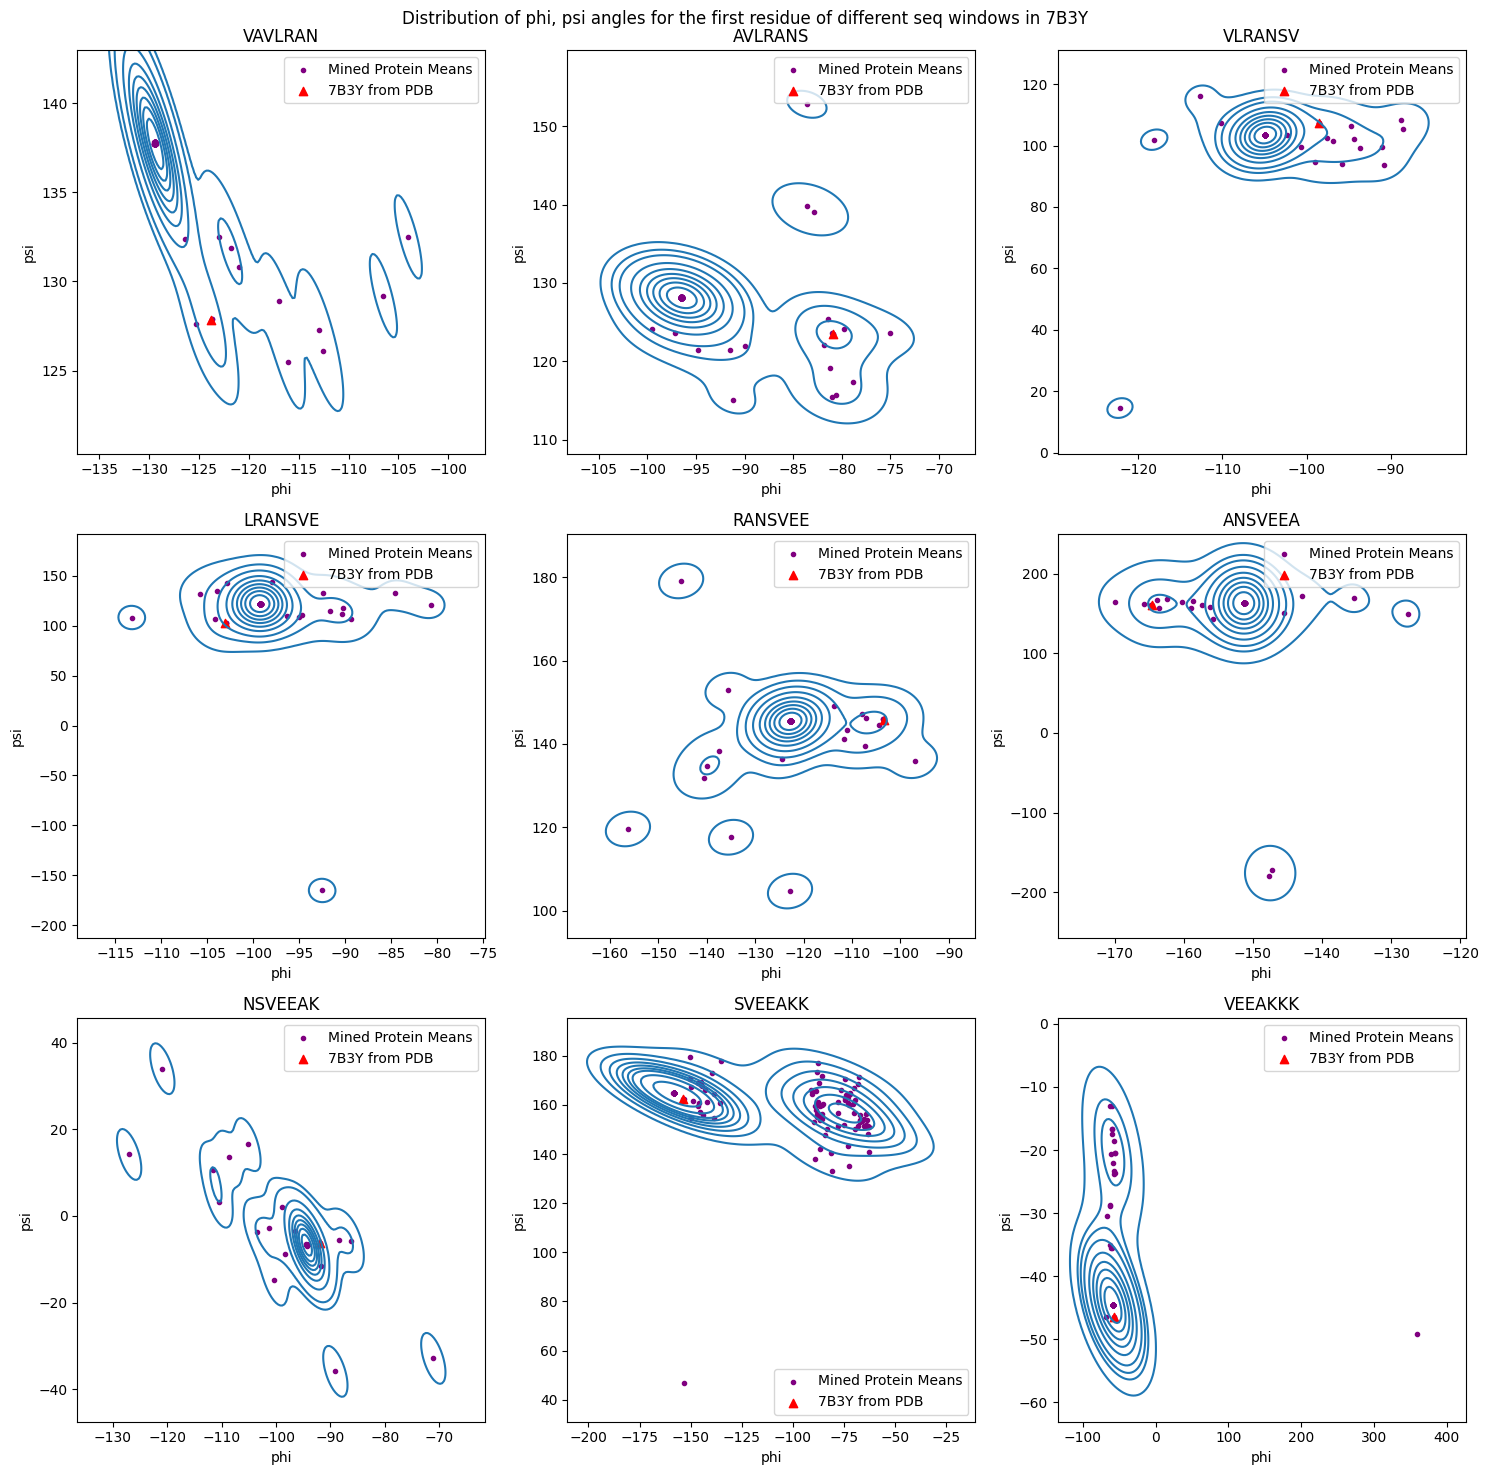

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

protein_id_pdb = phi_psi.protein_id.unique()[0]
fig, axes = plt.subplots(3,3,figsize=(15,15))

m=10
for i,key in enumerate(phi_psi.seq.unique()[m:m+9]):
    ax = axes.flatten()[i]
    phi_psi_alpha = phi_psi[phi_psi.seq == key]
    phi_psi_dist = phi_psi_mined[(phi_psi_mined.seq == key) & (phi_psi_mined.protein_id != protein_id_pdb)]
    ax.scatter(phi_psi_dist['phi'], phi_psi_dist['psi'], label='Mined Protein Means', color='purple', marker='.')#, c=[{k:v for v,k in enumerate(phi_psi_dist['protein_id'].unique())}[x] for x in phi_psi_dist['protein_id']])
    sns.kdeplot(data=phi_psi_dist, x='phi', y='psi', ax=ax)
    ax.scatter(phi_psi_alpha['phi'], phi_psi_alpha['psi'], label=f'{protein_id_pdb} from PDB', color='red', marker='^')

    ax.legend()
    ax.set_title(key)
    ax.set_xlabel('phi')
    ax.set_ylabel('psi')
fig.suptitle(f'Distribution of phi, psi angles for the first residue of different seq windows in {protein_id_pdb}')
plt.tight_layout()